<a href="https://colab.research.google.com/github/Sapikzzz/AI-ASL/blob/main/CNN-Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
grassknoted_asl_alphabet_path = kagglehub.dataset_download('grassknoted/asl-alphabet')

print('Data source import complete.')


Data source import complete.


In [2]:
import numpy as np
import os
import cv2
from sklearn.utils import shuffle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import kagglehub
import seaborn as sns
import pandas as pd
import skimage
from skimage.transform import resize
from sklearn.metrics import classification_report, confusion_matrix
import os
from glob import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")
print(path)
train_path = os.path.join(path, '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train')

/kaggle/input/asl-alphabet


In [4]:
def plot_three_samples(letter):
    letter = letter.upper()
    print("Samples images for letter " + letter)
    img_path = os.path.join(train_path, letter, '*.jpg')
    path_contents = glob(img_path)

    if len(path_contents) < 3:
        print(f"Not enough images found for letter {letter}")
        return

    plt.figure(figsize=(16,16))
    imgs = random.sample(path_contents, 3)
    plt.subplot(131)
    plt.imshow(cv2.imread(imgs[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(imgs[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(imgs[2]))
    plt.show()

Samples images for letter B


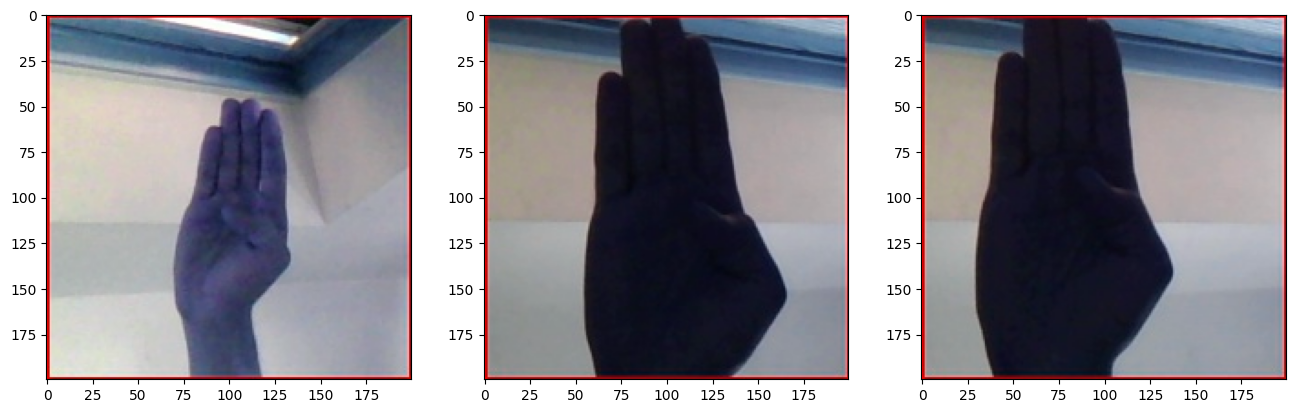

In [5]:
plot_three_samples('b')

In [6]:
# Check for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List all physical devices
tf.config.list_physical_devices()

# Verify TensorFlow is using GPU
tf.test.is_gpu_available()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Option 1: Enable memory growth (recommended for Kaggle)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU configured successfully")
    except RuntimeError as e:
        print("Error configuring GPU:", e)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Num GPUs Available:  1
GPU configured successfully


In [7]:
target_size = (64, 64)
target_dims = (64, 64, 3) # add channel for RGB
n_classes = 29
val_frac = 0.1
batch_size = 256

# Enhanced data augmentation
data_augmentor = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=val_frac
)

In [8]:
train_gen = data_augmentor.flow_from_directory(train_path, target_size=target_size, batch_size=batch_size, shuffle=True, subset='training')
val_gen = data_augmentor.flow_from_directory(train_path, target_size=target_size, batch_size=batch_size, subset='validation')

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

# Define the CNN model
model = Sequential([
    # First convolutional layer with ReLU activation
    Conv2D(32, kernel_size=3, activation='relu', strides=1, input_shape=(64, 64, 3)),  # 32 filters, kernel size 3x3, input size 64x64x3 (RGB image)
    BatchNormalization(), # Normalize inputs for faster convergence
    Conv2D(32, kernel_size=3, activation='relu', strides=2, input_shape=(64, 64, 3)),
    Dropout(0.5),

    # Second convolutional layer with ReLU activation
    Conv2D(64, kernel_size=3, strides=1, activation='relu'),  # 64 filters, kernel size 3x3
    BatchNormalization(),
    Conv2D(64, kernel_size=3, strides=2, activation='relu'),
    Dropout(0.5),

    # Third convolutional layer with ReLU activation
    Conv2D(128, strides=1, kernel_size=3, activation='relu'),  # 64 filters, kernel size 3x3
    BatchNormalization(),
    Conv2D(128, strides=2, kernel_size=3, activation='relu'),

    GlobalAveragePooling2D(),
    Dropout(0.5),

    # Fully connected dense layer with 128 neurons
    Dense(128, activation='relu'),

    # Output layer with 29 neurons (number of classes) and softmax activation
    Dense(29, activation='softmax'),  # Softmax activation for multi-class classification
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,157 (1.18 MB)

 Trainable params: 307,709 (1.17 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
model.compile(
    optimizer= Adam(learning_rate= 0.001),  # Use Adam optimizer for efficient training
    loss= 'categorical_crossentropy',  # Appropriate loss for multi-class classification
    metrics= ['accuracy']  # Track accuracy during training
)

In [11]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs= 10,
    batch_size = 256
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 644s 2s/step - accuracy: 0.1913 - loss: 2.7150 - val_accuracy: 0.1740 - val_loss: 2.6228
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 214s 700ms/step - accuracy: 0.6026 - loss: 1.1482 - val_accuracy: 0.7422 - val_loss: 0.7460
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 216s 707ms/step - accuracy: 0.7592 - loss: 0.6854 - val_accuracy: 0.7986 - val_loss: 0.5797
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 211s 691ms/step - accuracy: 0.8270 - loss: 0.5017 - val_accuracy: 0.8341 - val_loss: 0.4649
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 213s 697ms/step - accuracy: 0.8675 - loss: 0.3924 - val_accuracy: 0.8746 - val_loss: 0.3819
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 213s 698ms/step - accuracy: 0.8871 - loss: 0.3329 - val_accuracy: 0.8986 - val_loss: 0.3226
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 215s 701ms/step - accuracy: 0.9017 - loss: 0.2949 - val_accuracy: 0.8589 - val_loss: 0.4582
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 207s 677ms/step - accuracy: 0.9125 - lo